In [1]:
import torch

device = torch.device("mps")

In [2]:
device

device(type='mps')

In [19]:
import os
from torchvision import transforms, datasets, models
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# 1. 디바이스 설정
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# 2. 데이터 전처리: 사이즈를 통일시키자 (예: 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # 밝기·대비 랜덤 조절
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# 3. 데이터셋 로딩
data_dir = 'dataset'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 4. 이진 분류 모델 (pretrained resnet 사용)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # 2진 분류는 output 1개
model = model.to(device)

# 5. 손실함수 및 옵티마이저
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 6. 학습
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # (batch, 1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.4036
Epoch 2/10, Loss: 0.0782
Epoch 3/10, Loss: 0.0331
Epoch 4/10, Loss: 0.0204
Epoch 5/10, Loss: 0.0093
Epoch 6/10, Loss: 0.0058
Epoch 7/10, Loss: 0.0039
Epoch 8/10, Loss: 0.0041
Epoch 9/10, Loss: 0.0055
Epoch 10/10, Loss: 0.0025


Label: 0 (class: plugged)
Image Tensor Shape: torch.Size([3, 224, 224])


<module 'matplotlib.pyplot' from '/Users/gyuyeonjo/miniforge3/envs/torch/lib/python3.8/site-packages/matplotlib/pyplot.py'>

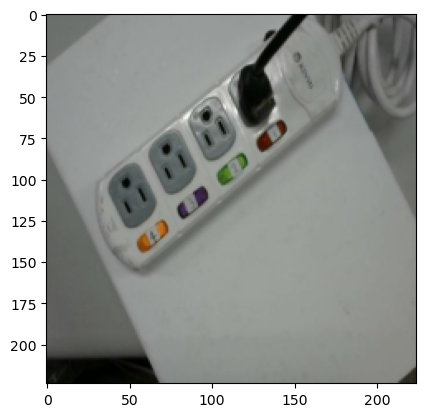

In [20]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

# 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 불러오기
dataset = ImageFolder(root='dataset', transform=transform)

# 한 쌍 가져오기
img_tensor, label = dataset[100]  # 첫 번째 샘플

print(f"Label: {label} (class: {dataset.classes[label]})")
print(f"Image Tensor Shape: {img_tensor.shape}")

# 시각화 (To show the image)
plt.imshow(img_tensor.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
plt


In [10]:
from PIL import Image
import torch
from torchvision import transforms

# transform 정의 (학습 시와 동일해야 함)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]
    )
])

def predict_image(img_path, threshold=0.5):  # threshold 낮춰봄
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        prob = torch.sigmoid(output).item()  # 확률

    print(f"Predicted score: {prob:.4f}")
    print("✅ Plugged In" if prob <= threshold else "❌ Unplugged")


In [21]:
predict_image('./test-dataset/1.jpeg')

Predicted score: 0.0194
✅ Plugged In


In [22]:
predict_image('./test-dataset/5.jpeg')

Predicted score: 0.9885
❌ Unplugged


In [23]:
predict_image('./test-dataset/3.jpeg')

Predicted score: 0.0062
✅ Plugged In


In [25]:
predict_image('./test-dataset/4.jpeg')

Predicted score: 0.9790
❌ Unplugged


In [26]:
predict_image('./test-dataset/2.jpeg')

Predicted score: 0.9955
❌ Unplugged


In [27]:
import torch

# 모델 정의 및 학습이 끝난 후
torch.save(model.state_dict(), 'model.pth')  # 모델 가중치 저장
# 또는 전체 모델 저장
torch.save(model, 'full_model.pth')

In [28]:
!pip install azure-storage-blob

In [ ]:
from azure.storage.blob import BlobServiceClient

connection_string = "DefaultEndpointsProtocol=https;AccountName=netzero25account;AccountKey=RZowAl7S5wZijzYGJlfvA1tsJSjgxAPc3kypCbdl4QpKslvbJS9I65d8BbLb32zsF2eJeUHj4DfU+ASt0s6B8g==;EndpointSuffix=core.windows.net"
container_name = "netzero-container"
blob_name = "full_model.pth"
local_file_path = "./full_model.pth"

blob_service = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service.get_blob_client(container=container_name, blob=blob_name)

with open(local_file_path, "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

print("업로드 완료")

업로드 완료


In [30]:
!pip install fastapi uvicorn azure-storage-blob torch

In [90]:
from fastapi import FastAPI
from pydantic import BaseModel
import torch
from torchvision import models, transforms
from azure.storage.blob import BlobServiceClient
import os

app = FastAPI()

MODEL_PATH = "model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) 이미지 데이터 전처리 함수 (FastAPI 입력이 이미지파일이 아니면 맞게 조정 필요)
# 여기서는 단순 숫자 리스트로 테스트한다고 가정
class PredictInput(BaseModel):
    values: list[float]  # 이미지 데이터가 아니라 벡터일 경우

# 모델 다운로드
def download_model_from_blob():
    connection_string = "DefaultEndpointsProtocol=https;AccountName=...;AccountKey=...;EndpointSuffix=core.windows.net"
    container_name = "models"
    blob_name = "model.pth"

    if not os.path.exists(MODEL_PATH):
        blob_service = BlobServiceClient.from_connection_string(connection_string)
        blob_client = blob_service.get_blob_client(container=container_name, blob=blob_name)

        with open(MODEL_PATH, "wb") as f:
            f.write(blob_client.download_blob().readall())
        print("모델 다운로드 완료")

@app.on_event("startup")
def load_model():
    download_model_from_blob()
    global model
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.to(device)
    model.eval()

@app.post("/predict")
def predict(input: PredictInput):
    # 입력 데이터가 이미지가 아니라 벡터형태라고 가정했을 때
    # 실제 이미지 예측 API라면 이미지 파일 업로드 후 PIL로 불러와 transforms 적용 필요
    x = torch.tensor(input.values).float().to(device).unsqueeze(0)  # (1, 벡터길이)
    with torch.no_grad():
        y = model(x)
    pred = torch.sigmoid(y).item()  # BCEWithLogitsLoss 썼으니 sigmoid 씌우기
    return {"prediction": pred}


TypeError: 'type' object is not subscriptable

In [31]:
from azure.storage.blob import BlobServiceClient

connection_string = "DefaultEndpointsProtocol=https;AccountName=netzero25account;AccountKey=RZowAl7S5wZijzYGJlfvA1tsJSjgxAPc3kypCbdl4QpKslvbJS9I65d8BbLb32zsF2eJeUHj4DfU+ASt0s6B8g==;EndpointSuffix=core.windows.net"
container_name = "netzero-container"
blob_name = "full_model.pth"
local_file_path = "./full_model_downloaded.pth"  # 저장 경로

# 클라이언트 설정
blob_service = BlobServiceClient.from_connection_string(connection_string)
blob_client = blob_service.get_blob_client(container=container_name, blob=blob_name)

# 다운로드
with open(local_file_path, "wb") as file:
    download_stream = blob_client.download_blob()
    file.write(download_stream.readall())

print("✅ 모델 다운로드 완료")


✅ 모델 다운로드 완료


In [32]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 전체 불러오기
model = torch.load(local_file_path, map_location=device)
model = model.to(device)
model.eval()


/var/folders/gt/0rjz50991_387k9xggv9vwww0000gn/T/ipykernel_50334/1199956703.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(local_file_path, map_locat

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
from PIL import Image
from torchvision import transforms

# transform 정의 (학습 시와 동일하게)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]
    )
])

def predict_image(img_path, threshold=0.5):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img)
        prob = torch.sigmoid(output).item()

    print(f"Predicted score: {prob:.4f}")
    print("✅ Plugged In" if prob <= threshold else "❌ Unplugged")


In [40]:
predict_image("/Users/gyuyeonjo/Desktop/dataset/test-dataset/5.jpeg")

Predicted score: 0.8873
❌ Unplugged
